In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import itertools
from itertools import combinations
from PIL import Image
import math
import random
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
locations_history=pd.read_csv("/content/s.csv")
print(locations_history)

      Index  Latitude  Longitude       2010       2011       2012       2013  \
0         0  24.66818   71.33144   8.475744   8.868568   9.202181   6.023070   
1         1  24.66818   71.41106  24.029778  28.551348  25.866415  21.634459   
2         2  24.66818   71.49069  44.831635  66.111168  56.982258  53.003735   
3         3  24.66818   71.57031  59.974419  80.821304  78.956543  63.160561   
4         4  24.66818   71.64994  14.653370  19.327524  21.928144  17.899586   
...     ...       ...        ...        ...        ...        ...        ...   
2413   2413  20.15456   72.84432   5.199882   4.516778   4.321080   2.658953   
2414   2414  20.15456   72.92394   0.122287   0.126717   0.101494   0.111509   
2415   2415  20.15456   73.00357   0.039415   0.040843   0.032713   0.035941   
2416   2416  20.15456   73.08319   2.719220   1.370163   0.818687   1.205721   
2417   2417  20.15456   73.16282   0.621228   0.238414   0.112909   0.209801   

           2014       2015       2016  

In [ ]:
df=pd.read_csv("/content/s.csv")


In [ ]:
df_new= locations_history.drop(['Latitude','Longitude','Index'],axis=1)


In [ ]:
dist_matrix=pd.read_csv("/content/drive/MyDrive/Shell_Hackathon/Distance_Matrix.csv")
print(dist_matrix.shape)
dist=np.zeros((2418,2418))
for i in range(2418):
  dist[i]=np.array(dist_matrix[str(i)])
print(dist_matrix.shape)

(2418, 2419)
(2418, 2419)


In [ ]:
lat=locations_history["Latitude"]
lon=locations_history["Longitude"]
fig, axs = plt.subplots(4, 2, figsize=(30, 40))
for i in range(2):
  for j in range(4):
    plt.subplot(4,2,4*i+j+1)
    axs[j,i].set_xlabel("Longitude")
    axs[j,i].set_ylabel("Latitude")
    axs[j,i].set_title(str(2010+4*i+j))
    sc = plt.scatter(lon, lat, c=locations_history[str(2010+4*i+j)],cmap='plasma', s=70, marker='s', edgecolors='black')
    cbar = plt.colorbar(sc)
    cbar.set_label('locations Production')

plt.show()



In [ ]:
image_data=np.zeros(shape=(8,2418))
for i in range(8):
  arr=np.array(locations_history[str(2010+i)])
  print(f'Year {str(2010+i)} total locations {np.sum(arr)}')
  image_data[i]=arr

In [ ]:
decay=0.001
df_new["2018"]=0
df_new=df_new.apply(lambda row: row.ewm(alpha=decay).mean(), axis=1)
df_new["2019"]=0
df_new=df_new.apply(lambda row: row.ewm(alpha=decay).mean(), axis=1)
print(df_new)

           2010       2011       2012       2013       2014       2015  \
0      8.475744   8.574049   8.665815   8.534543   8.562078   8.523914   
1     24.029778  25.161301  25.491128  25.372985  25.679612  25.896840   
2     44.831635  50.156842  52.099527  52.884351  53.985112  54.276187   
3     59.974419  65.191356  67.882622  68.595326  69.937991  70.690946   
4     14.653370  15.823078  16.762582  17.185996  17.483430  17.695556   
...         ...        ...        ...        ...        ...        ...   
2413   5.199882   5.028935   4.912157   4.727140   4.653912   4.631333   
2414   0.122287   0.123395   0.121203   0.119774   0.119168   0.118923   
2415   0.039415   0.039772   0.039066   0.038605   0.038409   0.038331   
2416   2.719220   2.381618   2.132627   1.981196   1.881849   1.811116   
2417   0.621228   0.525429   0.458224   0.417461   0.390339   0.370814   

           2016       2017       2018       2019  
0      8.477236   8.394743   8.233269   7.406230  
1     26.

In [ ]:
arr=np.array(df_new['2018'])
print(np.sum(arr))

374658.96515527996


0       10.525698
1       41.634834
2       68.347180
3       83.134020
4       21.493889
          ...    
2413     3.975644
2414     2.309994
2415     2.546213
2416     3.398638
2417     3.255372
Name: 2019, Length: 2418, dtype: float64


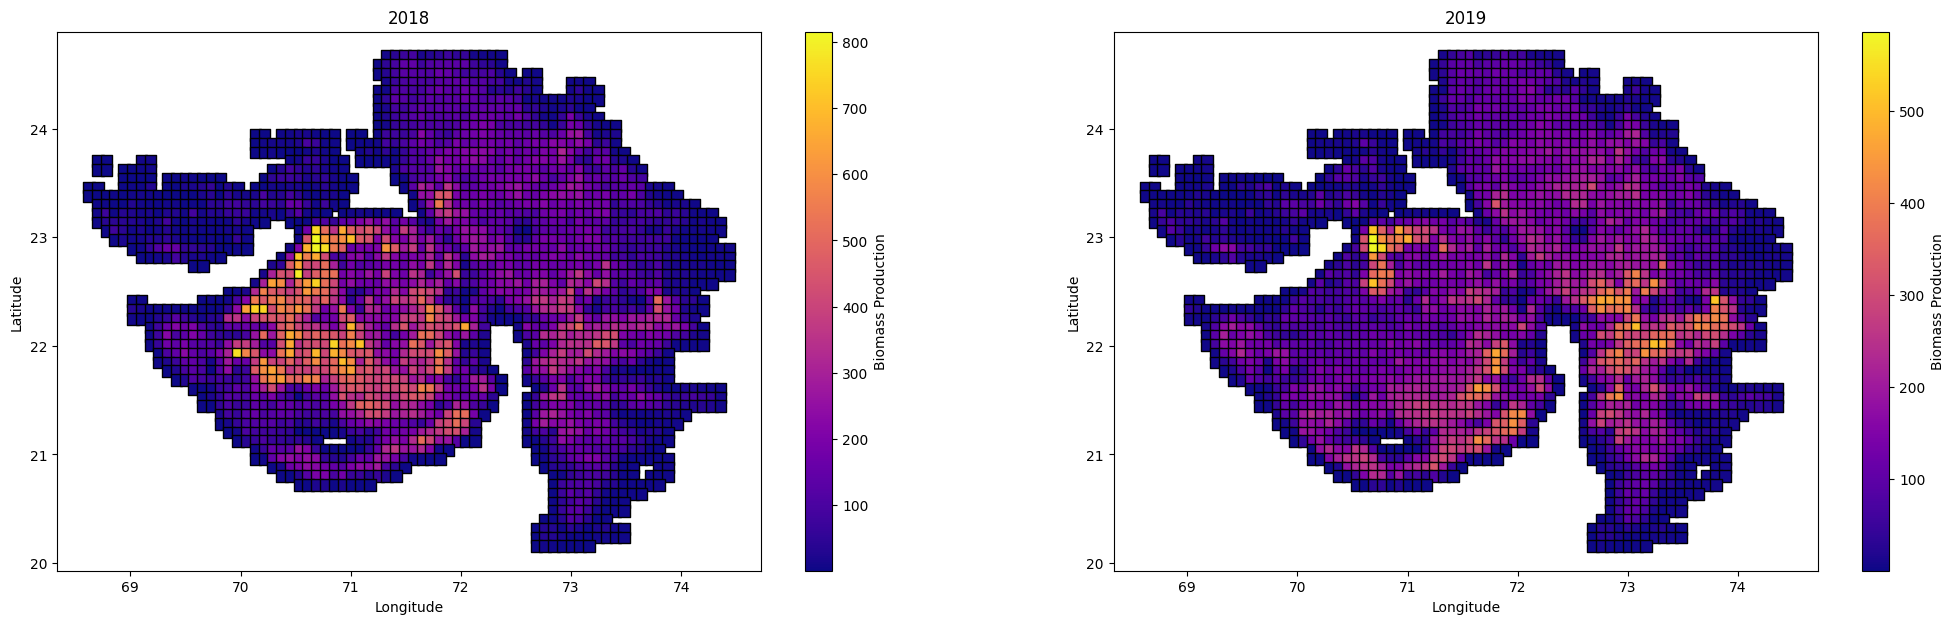

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(25, 7))
print(df_new["2019"])
for i in range(2):
  plt.subplot(1,2,i+1)
  axs[i].set_xlabel("Longitude")
  axs[i].set_ylabel("Latitude")
  axs[i].set_title(str(2018+i))
  sc = plt.scatter(lon, lat, c=df_new[str(2018+i)],cmap='plasma', s=70, marker='s', edgecolors='black')
  cbar = plt.colorbar(sc)
  cbar.set_label('Locations Production')

plt.show()

In [ ]:
arr=np.array(df_new["2019"])
arr2=np.array(df_new['2018'])
print(np.sum(np.abs(arr-arr2)))

123386.41965284999


In [ ]:
def get_comb(tpl):
  return tpl[0]
def get_cost(arr,dic):
    total_locations=0
    cost_under=0
    done=[]
    trans=0
    leftovers=np.zeros((2418))
    underutil=np.zeros((len(arr)))

    for i in range(len(arr)):
        dt=[dist[j,int(arr[i])] for j in dic[(arr[i])]][0]
        points=[j for j in dic[(arr[i])]][0]
        produce=[df_new["2019"].to_numpy()[j] for j in dic[(arr[i])]][0]
        comb=np.multiply(dt,produce)
        final=[(comb[k],produce[k],points[k]) for k in range(len(dt))]
        sorted_final=sorted(final,key=get_comb)
        cap=0
        idx=0
        while cap<20000 and idx<len(points):
          cap+=produce[idx]
          if (cap<20000):
            leftovers[points[idx]]=1
            hello=(produce[idx],points[idx],arr[i])
            trans+=comb[idx]
            total_locations+=produce[idx]
            idx+=1
            done.append(hello)
          else:
            cap=cap-produce[idx]
            break
            # print(hello)
        if cap==20000:
          underutil[i]=0
          cost_under+=0
        elif(cap<20000):
          underutil[i]=(20000-cap)
          cost_under+=(20000-cap)
    left=np.where(leftovers==0)

    return cost_under, (trans/1000)+cost_under,total_locations, done, trans, left,underutil
def get_cluster(random_points):
    cluster=np.zeros((2418))
    for i in range(2418):
        dt=10000
        c=-1
        for j in random_points:
          if (dist[i][j]<dt):
            dt=dist[i][j]
            c=j
        cluster[i]=c
    return cluster

In [ ]:
def get_cap(tpl):
  return tpl[1]
def optimize(depot_underutil,leftovers,depots,total_cost,transportation_cost,cost_under_utilization,all_tuples):
  left_tuple=[(leftovers[0][k],array[leftovers[0][k]]) for k in range(len(leftovers[0]))]
  sorted_left=sorted(left_tuple,key=get_cap,reverse=True)
  for i in sorted_left:
    bio=i[1]
    gridpoint=i[0]
    dist_depots=[(depots[k],dist[int(gridpoint)][int(depots[k])],depot_underutil[k]) for k in range(len(depots))]
    dist_depots=sorted(dist_depots,key=get_cap)
    while(bio>0):
      if(len(dist_depots)>0 and bio>dist_depots[0][2]):
        bio-=dist_depots[0][2]
        all_tuples.append((dist_depots[0][2],gridpoint,dist_depots[0][0]))
        cost_under_utilization-=dist_depots[0][2]
        transportation_cost+=((dist_depots[0][2]*dist_depots[0][1])/1000)
        total_cost-=dist_depots[0][2]
        total_cost+=((dist_depots[0][2]*dist_depots[0][1])/1000)
        index=np.argwhere(depots==(dist_depots[0][0]))
        depot_underutil=np.delete(depot_underutil,(index[0][0]))
        for i in range(len(dist_depots)):
          if(dist_depots[i][0]==depots[index[0][0]]):
              dist_depots.pop(i)
              break
        depots=np.delete(depots,index[0][0])

      elif(len(dist_depots)>0 and bio<=dist_depots[0][2]):
        total_cost-=bio
        all_tuples.append((bio,gridpoint,dist_depots[0][0]))
        total_cost+=((bio*dist_depots[0][1])/1000)
        index=np.argwhere(depots==(dist_depots[0][0]))
        cost_under_utilization-=bio
        transportation_cost+=((bio*dist_depots[0][1])/1000)
        depot_underutil[index[0][0]]-=bio
        bio=0
      else:
        break
  return depot_underutil,leftovers,depots,total_cost,cost_under_utilization,transportation_cost,all_tuples


In [ ]:
block1 = df[(df['Longitude'] < 72.4) & (df['Latitude'] < 23.2)]
block2 = df[(df['Longitude'] > 72.8) & (df['Latitude'] < 23.2)]
block3 = df[df['Latitude'] > 23.5]


selected_indexes = []
if not block1.empty:
    selected_indexes.append(random.choice(block1.index))
if not block2.empty:
    selected_indexes.append(random.choice(block2.index))
if not block3.empty:
    selected_indexes.append(random.choice(block3.index))

print("Selected Indexes:", selected_indexes)

Selected Indexes: [874, 1834, 321]


In [ ]:
f=0
total_cost=sys.maxsize
transportation_cost=sys.maxsize
cost_under_utilization=sys.maxsize
all_tuples=[]
utilization_amount=0
Best_number_of_clusters=30
array=np.array(df_new["2019"])
leftovers=np.array(0)
depots=np.array(0)
depot_underutil=np.array(0)
for i in range(10):
  number_of_clusters=random.sample(range(15,16),1)[0]
  print(number_of_clusters)
  random_points = random.sample(range(0, 2417), number_of_clusters)
  total_cost1=sys.maxsize
  transportation_cost1=sys.maxsize
  cost_under_utilization1=sys.maxsize
  all_tuples1=[]
  utilization_amount1=0
  leftovers1=np.array(0)
  depots1=np.array(0)
  depot_underutil1=np.array(0)
  Best_number_of_clusters1=12
  print(i,end="-")
  for ctr in range(20):
    cost_under=0
    cluster=get_cluster(random_points)
    dic={}
    arr=np.unique(cluster)
    for i in range(len(arr)):
            dic[arr[i]]=(np.where(cluster==arr[i]))

    change_cluster=random.choice(random_points)
    points_inside=dic[change_cluster]
    point_chosen=random.choice(points_inside[0])
    random_new=random_points
    index=random_points.index(change_cluster)
    random_new[index]=point_chosen
    cluster_new=get_cluster(random_new)
    arr_new=np.unique(cluster_new)
    dic_new={}
    for i in range(len(arr_new)):
            dic_new[arr_new[i]]=(np.where(cluster_new==arr_new[i]))
    under,total,total_locations,final,trans,left,util=get_cost(arr,dic)
    under1,total1,total_locations1,final1,trans1,left1,util1=get_cost(arr_new,dic_new)
    best_util=total_locations/np.sum(array)
    best_util1=total_locations1/np.sum(array)
    if(total1<total and total1<total_cost1):
      utilization_amount1=best_util1
      total_cost1=total1
      transportation_cost1=(trans1/1000)
      cost_under_utilization1=under1
      all_tuples1=final1
      random_points1=random_new
      Best_number_of_clusters1=number_of_clusters
      leftovers1=left1
      depot_underutil1=util1
      depots1=arr_new


    elif(total<total_cost1):
      utilization_amount1=best_util
      total_cost1=total
      transportation_cost1=(trans/1000)
      cost_under_utilization1=under
      all_tuples1=final
      Best_number_of_clusters1=number_of_clusters
      leftovers1=left
      depot_underutil1=util
      depots1=arr

  # print(total_cost1)
  if(leftovers1):
    depot_underutil2,leftovers2,depots2,total_cost2,cost_under_utilization2,transportation_cost2,all_tuples2=optimize(depot_underutil1,leftovers1,depots1,total_cost1,transportation_cost1,cost_under_utilization1,all_tuples1)
    total_bio=utilization_amount1*np.sum(array)
    final_util=(total_bio+np.abs(cost_under_utilization2-cost_under_utilization1))/np.sum(array)
    if(total_cost2<total_cost and final_util>0.8):
      utilization_amount=final_util
      total_cost=total_cost2
      transportation_cost=transportation_cost2
      cost_under_utilization=cost_under_utilization2
      all_tuples=all_tuples2
      Best_number_of_clusters=Best_number_of_clusters1
      leftovers=leftovers2
      depot_underutil=depot_underutil2
      depots=depots1
    # print(total_cost2)
  print(total_cost1,total_cost)



print(f'Total cost - {total_cost}')
print(f'Transportation cost - {transportation_cost}')
print(f'Cost under utilization -{cost_under_utilization}')
print(f'Utilization amount - {utilization_amount}')
print(f'Number of clusters - {Best_number_of_clusters}')

    # print(f'Left-{leftovers}')

15
0-135468.96124583817 73801.2345688502
15
1-129623.53481019974 61591.52592842237
15
2-90827.94283463628 48255.56728907708
15
3-80857.24358638535 48206.4678720429
15
4-116252.79833992304 48206.4678720429
15
5-106597.24939162348 48206.4678720429
15
6-98604.03066921218 48206.4678720429
15
7-111993.51692176974 48206.4678720429
15
8-83992.08942257444 43062.628221855106
15
9-119411.03621070336 43062.628221855106
Total cost - 43062.628221855106
Transportation cost - 22965.775656465084
Cost under utilization -20096.85256539003
Utilization amount - 0.999999999999999
Number of clusters - 15


In [ ]:
print(all_tuples)

[(10.525698, 0, 38.0), (41.634834, 1, 38.0), (68.34718, 2, 38.0), (83.13402, 3, 38.0), (21.493889, 4, 38.0), (32.98347, 5, 38.0), (45.520985, 6, 38.0), (81.44037, 7, 38.0), (48.428093, 8, 38.0), (57.744797, 9, 38.0), (13.292852, 10, 38.0), (9.631765, 11, 38.0), (9.382673, 12, 38.0), (7.9835424, 13, 38.0), (7.2807403, 14, 38.0), (43.765846, 15, 38.0), (91.772766, 16, 38.0), (105.409, 17, 38.0), (107.30021, 18, 38.0), (71.97593, 19, 38.0), (94.45182, 20, 38.0), (98.70106, 21, 38.0), (115.925606, 22, 38.0), (112.78651, 23, 38.0), (101.84379, 24, 38.0), (87.279076, 25, 38.0), (53.71699, 26, 38.0), (39.871826, 27, 38.0), (9.121117, 28, 38.0), (6.640426, 29, 38.0), (30.85282, 30, 38.0), (87.577705, 31, 38.0), (118.35139, 32, 38.0), (111.84167, 33, 38.0), (108.679436, 34, 38.0), (99.88789, 35, 38.0), (125.701996, 36, 38.0), (118.41782, 37, 38.0), (108.39928, 38, 38.0), (81.61673, 39, 38.0), (93.56069, 40, 38.0), (107.02267, 41, 38.0), (103.98937, 42, 38.0), (30.18857, 43, 38.0), (7.7228217, 4

In [ ]:
def checker(all_tuples):
  used_bio=0
  dept=np.array(())
  for i in range(len(all_tuples)):
    used_bio+=all_tuples[i][0]
    dept=np.append(dept,all_tuples[i][2])
  print(used_bio)
  print(np.unique(dept))
  for j in range (depots.shape[0]):
    toal_locations_one_depot=0
    for i in range(len(all_tuples)):
      if (all_tuples[i][2]==depots[j]):
        toal_locations_one_depot+=all_tuples[i][0]
    # print(depots[j],toal_locations_one_depot)
  count=0
  for i in range(len(all_tuples)):
    if (all_tuples[i][0]<=array[int(all_tuples[i][1])]):
      count+=1
    else:
      print(all_tuples[i][0],array[int(all_tuples[i][1])],all_tuples[i][1])
  for i in range (len(all_tuples)):
    off=0
    for j in range (len(all_tuples)):
      if (all_tuples[j][1]==all_tuples[i][1]):
        off+=all_tuples[j][0]
    if (off>array[int(all_tuples[i][1])]):
      print(off,all_tuples[i][1],array[int(all_tuples[i][1])])

  print(count)
checker(all_tuples)
print(np.sum(array))
print(depots)

279903.14743460965
[  38.  306.  414.  662.  881.  994. 1129. 1395. 1407. 1847. 1869. 1889.
 1916. 1997. 2358.]
2431
279903.14743461
[  38.  306.  414.  662.  881.  994. 1129. 1395. 1407. 1847. 1869. 1889.
 1916. 1997. 2358.]


In [ ]:
print(depots)

[  38.  306.  414.  662.  881.  994. 1129. 1395. 1407. 1847. 1869. 1889.
 1916. 1997. 2358.]


In [ ]:
warehouse = list(itertools.combinations(depots, 3))

In [ ]:
print(warehouse)

[(38.0, 306.0, 414.0), (38.0, 306.0, 662.0), (38.0, 306.0, 881.0), (38.0, 306.0, 994.0), (38.0, 306.0, 1129.0), (38.0, 306.0, 1395.0), (38.0, 306.0, 1407.0), (38.0, 306.0, 1847.0), (38.0, 306.0, 1869.0), (38.0, 306.0, 1889.0), (38.0, 306.0, 1916.0), (38.0, 306.0, 1997.0), (38.0, 306.0, 2358.0), (38.0, 414.0, 662.0), (38.0, 414.0, 881.0), (38.0, 414.0, 994.0), (38.0, 414.0, 1129.0), (38.0, 414.0, 1395.0), (38.0, 414.0, 1407.0), (38.0, 414.0, 1847.0), (38.0, 414.0, 1869.0), (38.0, 414.0, 1889.0), (38.0, 414.0, 1916.0), (38.0, 414.0, 1997.0), (38.0, 414.0, 2358.0), (38.0, 662.0, 881.0), (38.0, 662.0, 994.0), (38.0, 662.0, 1129.0), (38.0, 662.0, 1395.0), (38.0, 662.0, 1407.0), (38.0, 662.0, 1847.0), (38.0, 662.0, 1869.0), (38.0, 662.0, 1889.0), (38.0, 662.0, 1916.0), (38.0, 662.0, 1997.0), (38.0, 662.0, 2358.0), (38.0, 881.0, 994.0), (38.0, 881.0, 1129.0), (38.0, 881.0, 1395.0), (38.0, 881.0, 1407.0), (38.0, 881.0, 1847.0), (38.0, 881.0, 1869.0), (38.0, 881.0, 1889.0), (38.0, 881.0, 1916.0

In [ ]:
def sort(tpl):
  return tpl[0]

In [ ]:
def getcluster(depots,comb):
    cap={}
    for i in comb:
      cap[int(i)]=0
    dist_ref=[]
    cluster=np.zeros((depots.shape[0]))
    dic={}
    for i in range(depots.shape[0]):
        for j in comb:
            dt=dist[int(depots[i])][int(j)]
            dist_ref.append((dt,int(depots[i]),int(j),i))
    dist_ref=sorted(dist_ref,key=sort)
    for k in dist_ref:
      if(int(k[1]) not in dic.keys() and cap[int(k[2])]<5):
        dic[int(k[1])]=1
        cluster[k[3]]=k[2]
        cap[k[2]]+=1
      else:
        continue
    return cluster
def getcostref(clusters):
  dic={}
  comb=np.unique(clusters)
  for k in comb:
    dic[int(k)]=[]
  for i in range(len(clusters)):
    dic[int(clusters[i])].append(int(depots[i]))
  costref=[]
  for i in comb:
    arr=dic[i]
    for p in range(2418):
      tc=sys.maxsize
      trans=0
      for j in arr:
        trans+=(dist[j][p]*20)
      if(trans<tc):
        tc=trans
    costref.append(tc)
    # print(tc)
  print(np.sum(np.array(costref)))
  # print(costref)
# for comb in warehouse:
#   cluster_ref=getcluster(depots,comb)
#   getcostref(cluster_ref)
for i in range(10):
  comb = random.sample(range(0, 2417), 3)
  cluster_ref=getcluster(depots,comb)
  getcostref(cluster_ref)

142798.712
142798.712
142798.712
142798.712
142798.712
142798.712
142798.712
142798.712
142798.712
142798.712


In [ ]:
print(warehouse)

[(38.0, 306.0, 414.0), (38.0, 306.0, 662.0), (38.0, 306.0, 881.0), (38.0, 306.0, 994.0), (38.0, 306.0, 1129.0), (38.0, 306.0, 1395.0), (38.0, 306.0, 1407.0), (38.0, 306.0, 1847.0), (38.0, 306.0, 1869.0), (38.0, 306.0, 1889.0), (38.0, 306.0, 1916.0), (38.0, 306.0, 1997.0), (38.0, 306.0, 2358.0), (38.0, 414.0, 662.0), (38.0, 414.0, 881.0), (38.0, 414.0, 994.0), (38.0, 414.0, 1129.0), (38.0, 414.0, 1395.0), (38.0, 414.0, 1407.0), (38.0, 414.0, 1847.0), (38.0, 414.0, 1869.0), (38.0, 414.0, 1889.0), (38.0, 414.0, 1916.0), (38.0, 414.0, 1997.0), (38.0, 414.0, 2358.0), (38.0, 662.0, 881.0), (38.0, 662.0, 994.0), (38.0, 662.0, 1129.0), (38.0, 662.0, 1395.0), (38.0, 662.0, 1407.0), (38.0, 662.0, 1847.0), (38.0, 662.0, 1869.0), (38.0, 662.0, 1889.0), (38.0, 662.0, 1916.0), (38.0, 662.0, 1997.0), (38.0, 662.0, 2358.0), (38.0, 881.0, 994.0), (38.0, 881.0, 1129.0), (38.0, 881.0, 1395.0), (38.0, 881.0, 1407.0), (38.0, 881.0, 1847.0), (38.0, 881.0, 1869.0), (38.0, 881.0, 1889.0), (38.0, 881.0, 1916.0

In [ ]:

print(warehouse[0])
cluster_ref=getcluster(depots,warehouse[0])
print(depots)
print(depot_underutil)


(38.0, 306.0, 414.0)
[  38.  306.  414.  662.  881.  994. 1129. 1395. 1407. 1847. 1869. 1889.
 1916. 1997. 2358.]
[15420.26373766  4676.58882773]


In [ ]:
def getcostref(clusters):
  dic={}
  comb=np.unique(clusters)
  for k in comb:
    dic[int(k)]=[]
  for i in range(len(clusters)):
    dic[int(clusters[i])].append(int(depots[i]))
  costref=[]
  for i in comb:
    arr=dic[i]
    for p in range(2418):
      tc=sys.maxsize
      trans=0
      for j in arr:
        trans+=dist[j][p]*20
      if(trans<tc):
        tc=trans
    costref.append(trans)
  print(costref)
getcostref(cluster_ref)

[33554.554, 44507.79, 64736.368]


In [ ]:
for i in dist[0]:
  if (i<50):
    print(i)

0.0
11.3769
20.4557
38.1227
45.381
25.7233
9.5233
14.0595
24.3136
37.8461
45.7319
30.3211
21.160400000000003
21.4279
30.824
33.2092
30.1792
31.6174
34.786300000000004
40.5325
41.4246
40.3339
47.3799
